<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

En esta tarea aplicaremos el procedimiento de predicción de precios de casas desarrollado en el libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/) de la `sección 10.14.1 California Housing`.

Usaremos el modelo de aumento de gradiente **(Gradient Boosting)** para producir un modelo predictivo a partir de un conjunto de modelos predictivos débiles **(weak)**, usando la función **ensemble.GradientBoostingRegressor** de la librería **sklearn**. El **Gradient Boosting** se puede utilizar para problemas de regresión y clasificación. En esta tarea, entrenaremos un modelo de regresión para predecir demanda eléctrica usando datos de demanda de días semejantes. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)


In [11]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores

## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores

X_train = df1.to_numpy()   ## Predictors
y_train = df2.to_numpy()   ## Outcome

X_test = dft1.to_numpy()   ## Predictors
y_test = dft2.to_numpy()   ## Outcome

Obtendremos los resultados con una función de pérdida por diferencia absoluta. Como parámetros del modelo usaremos 500 árboles de regresión `n_estimators=500`, con un número profundidad `max_depth=6` y una tasa de aprendizaje de `learning_rate": 0.01`.

In [12]:
params = { "n_estimators": 1000,
           "max_depth": 6,
           "min_samples_split": 5,
           "learning_rate": 0.1,
           "loss": "absolute_error",} # "squared_error", "absolute_error", "huber", "quantile"

Ahora, ajustaremos un modelo **Gradient Boosting** con nuestros datos de entrenamiento. y calculamos el error cuadrático medio (MAE) en los datos de prueba.

In [13]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mae  = mean_absolute_error(y_test, reg.predict(X_test))
msd  = mean_squared_error(y_test, reg.predict(X_test))
mape = mean_absolute_percentage_error(y_test, reg.predict(X_test))

print("El error medio absoluto (MAE) en datos de prueba es: {:.4f}".format(mae))
print("El error cuadrático medio (MSD) en datos de prueba es: {:.4f}".format(msd))
print("El error medio absoluto porcentual (MAPE) en datos de prueba es: {:.4f}".format(mape))

El error medio absoluto (MAE) en datos de prueba es: 191.8954
El error cuadrático medio (MSD) en datos de prueba es: 62677.8708
El error medio absoluto porcentual (MAPE) en datos de prueba es: 0.0220


Ahora visualizaremos el proceso de ajuste con los datos de entrenamiento y prueba. Calcularemos el error del conjunto de datos de entrenamiento y luego la compararemos con las iteraciones del conjunto de datos de prueba.

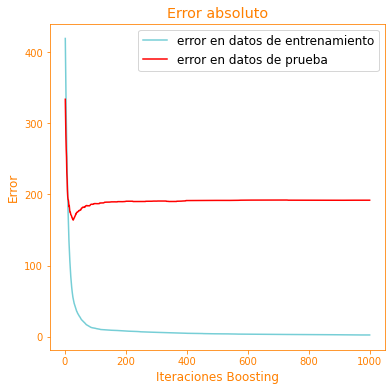

In [14]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
fig, ax = plt.subplots(figsize=(6,6))

plt.plot(np.arange(params["n_estimators"]) + 1,reg.train_score_,CYAN,label="error en datos de entrenamiento",)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="error en datos de prueba")
plt.legend(loc="upper right")

plt.xlabel("Iteraciones Boosting",fontsize='large',color = LETRASNARA)
plt.ylabel("Error",fontsize='large',color = LETRASNARA)
plt.title("Error absoluto"  ,fontsize='x-large',color = LETRASNARA)
plt.legend(fontsize='large')
plt.tick_params(colors = LETRASNARA, which='both')
ax.spines['bottom'].set_color(LETRASNARA)
ax.spines['top'   ].set_color(LETRASNARA) 
ax.spines['right' ].set_color(LETRASNARA)
ax.spines['left'  ].set_color(LETRASNARA)
namefile = 'fig_t10_1'
plt.savefig(namefile, transparent=True)
plt.show()


En la gráfica siguiente se muestra la importancia relativa de los predictores. Podemos observar  que los regresores `X11`, `X5` Y `X6` tienen una ligera importancia sobre los demás. Todas las demás variables tienen una relvancia ligeramente menos con un decremento monotónicamente decreciente.

No handles with labels found to put in legend.


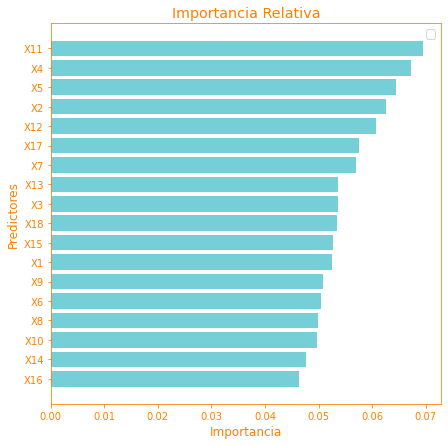

In [15]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig, ax = plt.subplots(figsize=(7,7))
plt.barh(pos, feature_importance[sorted_idx], align="center", color=CYAN)
plt.yticks(pos, np.array(['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18'])[sorted_idx])

plt.xlabel("Importancia",fontsize='large',color = LETRASNARA)
plt.ylabel("Predictores",fontsize='large',color = LETRASNARA)
plt.title("Importancia Relativa"  ,fontsize='x-large',color = LETRASNARA)
plt.legend(fontsize='large')
plt.tick_params(colors = LETRASNARA, which='both')
ax.spines['bottom'].set_color(LETRASNARA)
ax.spines['top'   ].set_color(LETRASNARA) 
ax.spines['right' ].set_color(LETRASNARA)
ax.spines['left'  ].set_color(LETRASNARA)
namefile = 'fig_t10_2'
plt.savefig(namefile, transparent=True)
plt.show()

La dependencia de cada una de las variables la podemos analizar por medio de las figuras siguientes. En el eje horizontal se observa el valor que ha tomado la variable con múltiples modelos débiles **(weak)**. Y en el eje vertical la relevancia relativa, todas las figuras tienen la misma escala así que la comparación es directa. Las discontinuidades que se observan en las figuras se deben al uso del modelo de árbol. Podemos observar algunas figuras con una curva cuasi-horizontal cercana al cero que indica baja relevancia, tal es el caso de `X`. 

Tambien se observan algunos casos extremos en los deciles 1 y 10 como por ejemplo en `X`. En otros casos se observan en la misma figura simultamenamente relevancias altas positivas y negativas divididas por discontinuidades como por ejemplo en `X`. Otros predictores presentan relevancias relativamente más suaves en toda la distribución de los deciles como popr ejemplo `X`. Otras tienen una importancia más cercana al cero y son ruidosas como por ejemplo `X`.

Estas figuras nos pueden ayudar a tomar decisiones para hacer más esberto un modelo eliminanado variables o ponioendo espécial atención en algunas de las variables mas relevantes y sus rangos de sensibilidad.  

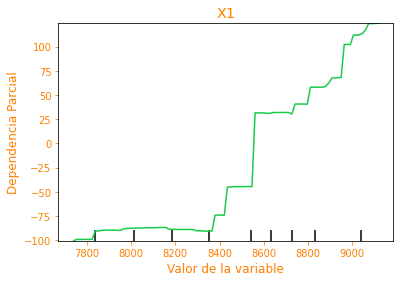

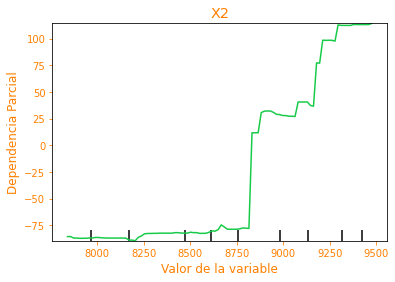

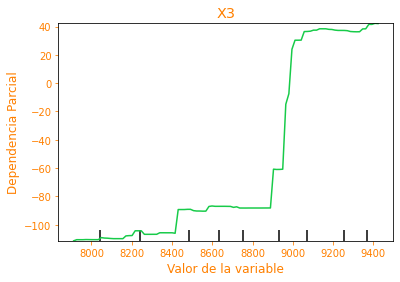

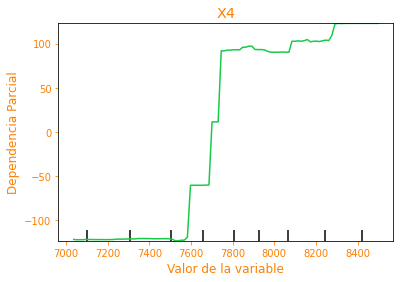

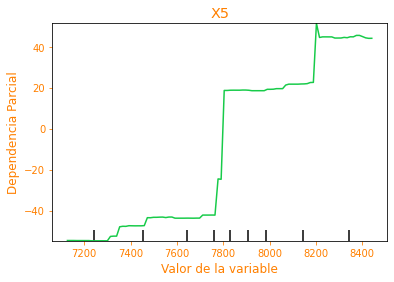

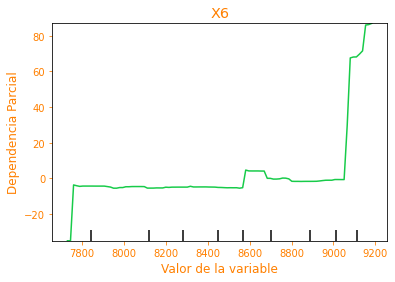

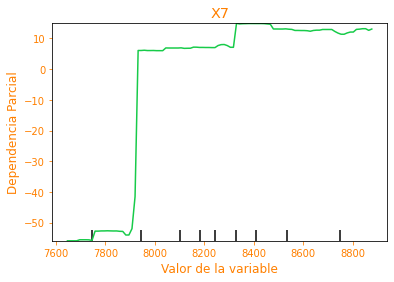

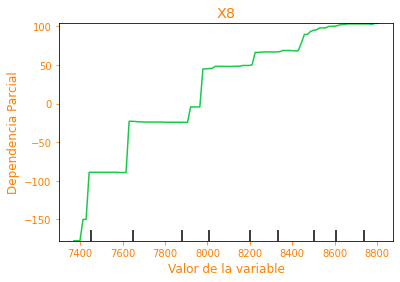

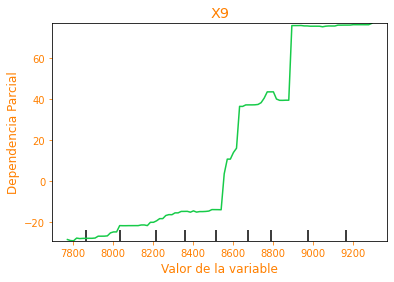

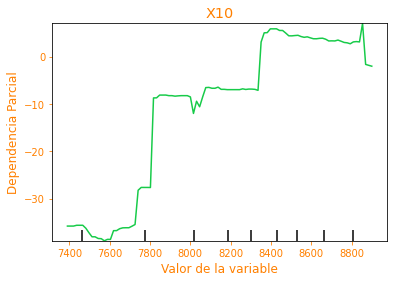

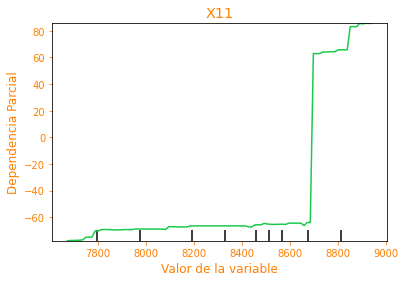

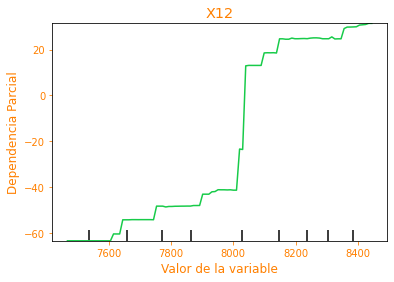

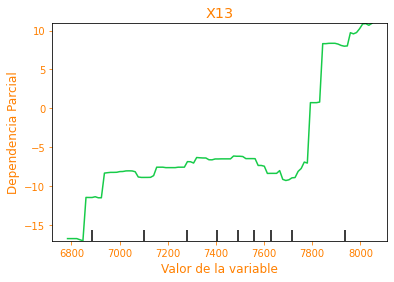

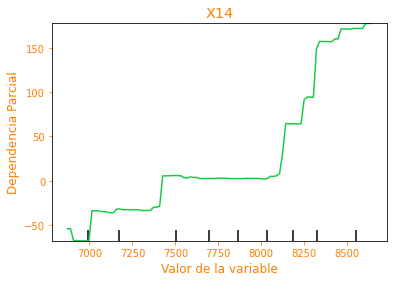

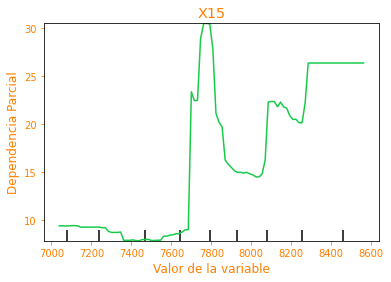

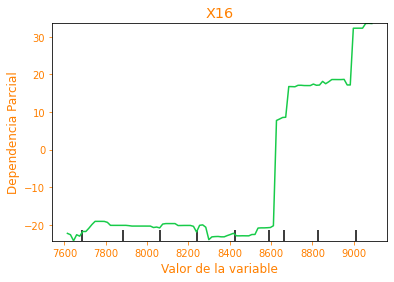

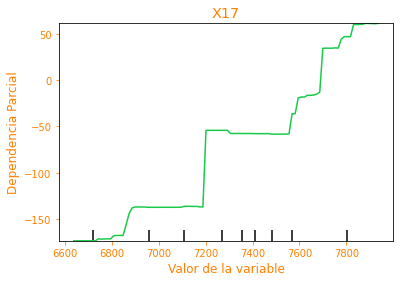

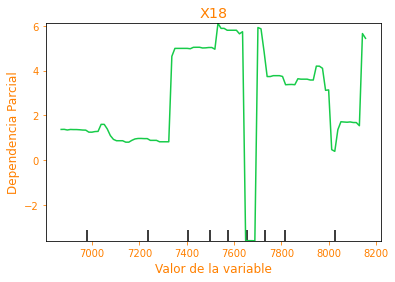

In [16]:
for features in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:  
    CYAN = '#76ced6'; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    PartialDependenceDisplay.from_estimator(reg, X_test, [features], line_kw={"color": VERDE})
    plt.title("X"+ str(features+1)   ,fontsize='x-large', color = LETRASNARA)
    plt.xlabel("Valor de la variable",fontsize='large',   color = LETRASNARA)
    plt.ylabel("Dependencia Parcial" ,fontsize='large',   color = LETRASNARA)
    plt.tick_params(colors = LETRASNARA, which='both')
    plt.tick_params(colors = LETRASNARA, which='both')
    namefile = 'fig_t10_X' + str(features+1)
    plt.savefig(namefile, transparent=False)

La figura que se muestra a continuación compara la relevancia entre las dos  variables principales, las zonas de color muestran la dependencia parcial entre las dos variables. Esta figura en dos dimensiones es semejante a la de tres dimensiones presentada en el libro en: `FIGURE 10.16. Partial dependence of house value on median age and average occupancy.`.

En este caso se observa una relación fuerte entre las dos principales variables `X5` y `X6` principalmente en los cuadrantes inferior-izquierdo y superior-derecho. 

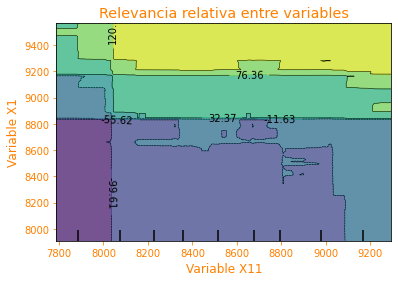

In [17]:
for features in [(11,1)]:
    PartialDependenceDisplay.from_estimator(reg, X_train, [features])
    plt.title("Relevancia relativa entre variables" ,fontsize='x-large', color = LETRASNARA)
    plt.xlabel("Variable X11",fontsize='large',   color = LETRASNARA)
    plt.ylabel("Variable X1", fontsize='large',   color = LETRASNARA)
    plt.tick_params(colors = LETRASNARA, which='both')
    plt.tick_params(colors = LETRASNARA, which='both')
    namefile = 'fig_t1_X_X_'
    plt.savefig(namefile, transparent=True)

### Ligas utilizadas

[Gradient Boosting regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html)

[sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

[Partial dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html)
